## Imports

In [1]:
import os
import sys
sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Cluster 24

<ol>
 <li><a href=#fold0>Fold 0</a></li>
 <li><a href=#fold1>Fold 1</a></li>
 <li><a href=#fold6>Fold 6</a></li>
 <li><a href=#fold7>Fold 7</a></li>
 <li><a href=#fold9>Fold 9</a></li>
</ol>

# Fold 0 <a name='fold0' />

In [2]:
cluster = '24'
fold = '0'
peak = 'overlap'
gwas = 'Kunkle'

gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

## Prepare Reference Alleles

In [3]:
major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 5


## Prepare Alternate Alleles

In [4]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 5


## Get Unique Loci

In [5]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))

seq_df = pd.DataFrame.from_dict(seq_dict)

loci = []
for i in seq_df.locus.unique():
    loci.append(i)
print("Number of Loci: ", len(seq_df.locus.unique()))
print("Unique Loci: ", loci)

Number of Loci:  1
Unique Loci:  [152]


## Find Alternate Alleles that Break Accessibility

In [6]:
seq_df_neg = seq_df.loc[seq_df['delta'] <= 0]
seq_df_neg.sort_values(by='delta', ascending=True, inplace=True)
display(seq_df_neg)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
4,4,chr1,40356154,40356155,rs6684490,152,A,G,3.780981,3.194430,-0.586551
2,2,chr1,40349427,40349428,rs61781270,152,G,A,-0.227992,-0.430026,-0.202034
1,1,chr1,40341761,40341762,rs144707726,152,C,CA,0.661952,0.652388,-0.009564


## Visualize Top Sequences

Index:  4  Importance:  3.7809811257000003  RSID:  rs6684490   chr1 : 40356154 - 40356155  Locus:  152
Major Allele:  A  Major Sequence:  GACTTCCCTATTTCAAAGAG


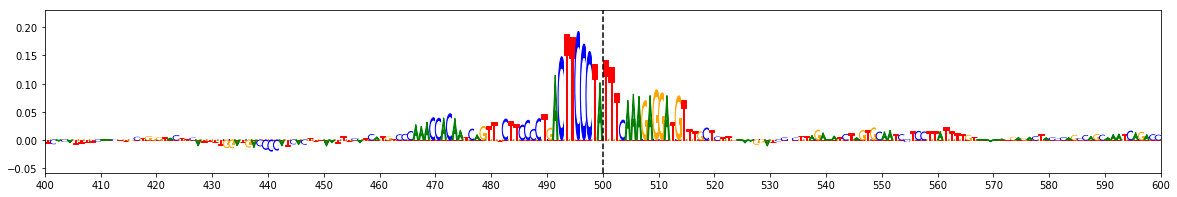

Index:  4  Importance:  3.1944300127000007  RSID:  rs6684490
Minor Allele:  G  Minor Sequence:  GACTTCCCTGTTTCAAAGAG


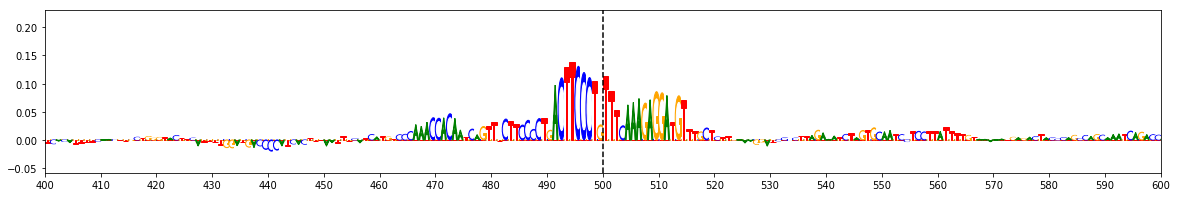

Index:  4  Delta:  -0.5865511129999996  RSID:  rs6684490
Minor - Major:  G - A


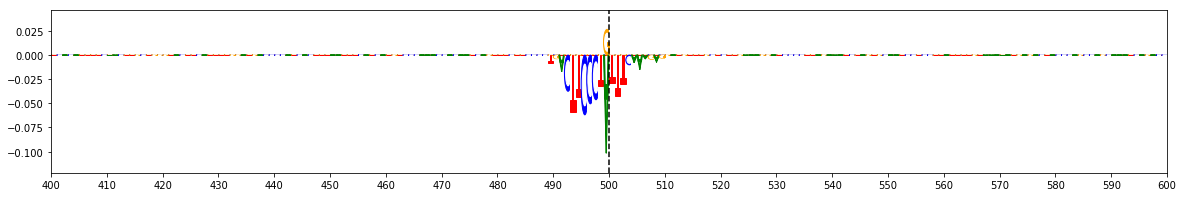

Index:  2  Importance:  -0.22799219740000004  RSID:  rs61781270   chr1 : 40349427 - 40349428  Locus:  152
Major Allele:  G  Major Sequence:  GCAACCTCCGCCTTCTGGGT


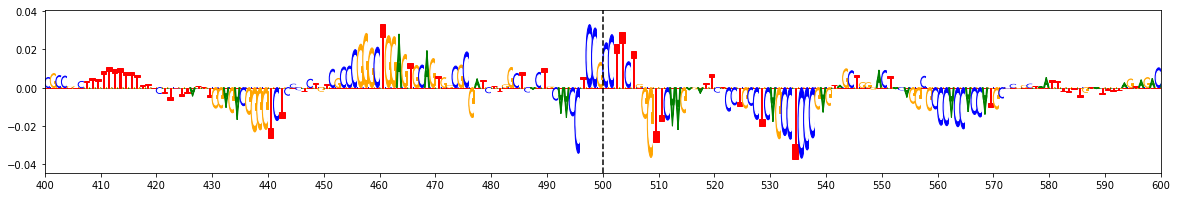

Index:  2  Importance:  -0.43002582859999994  RSID:  rs61781270
Minor Allele:  A  Minor Sequence:  GCAACCTCCACCTTCTGGGT


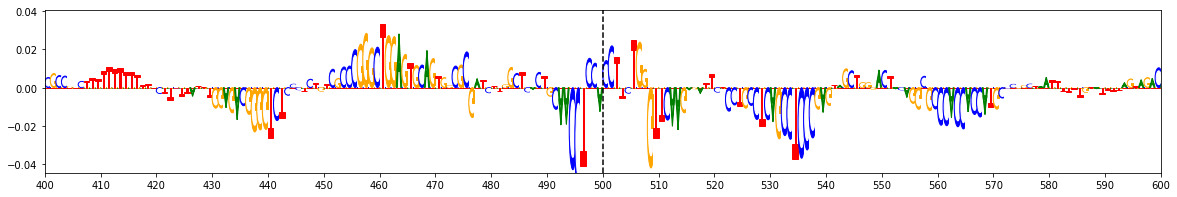

Index:  2  Delta:  -0.2020336311999999  RSID:  rs61781270
Minor - Major:  A - G


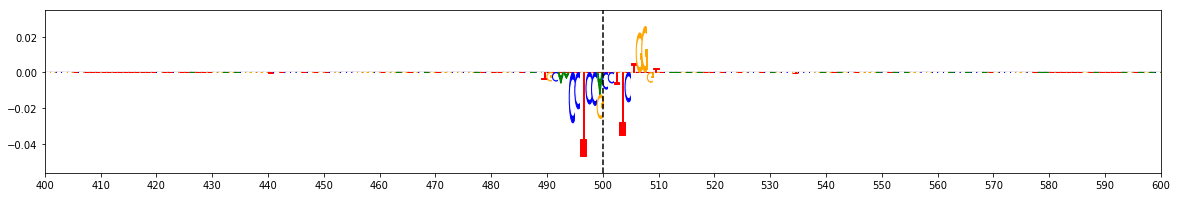

In [7]:
for idx in [4, 2]:
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df_neg.at[idx, 'chr'], ':', seq_df_neg.at[idx, 'start'], '-', seq_df_neg.at[idx, 'end'], " Locus: ", seq_df_neg.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_neg.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [8]:
seq_df_pos = seq_df.loc[seq_df['delta'] > 0]
seq_df_pos.sort_values(by='delta', ascending=False, inplace=True)
display(seq_df_pos)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
3,3,chr1,40349427,40349428,rs61781270,152,G,C,-0.227992,0.595054,0.823046
0,0,chr1,40299194,40299195,rs17504495,152,T,C,-0.241430,-0.057999,0.183431


## Visualize Top Sequences

Index:  3  Importance:  0.5950542182  RSID:  rs61781270 chr1 :  40349427  -  40349428  Locus:  152
Minor Allele:  C  Minor Sequence:  GCAACCTCCCCCTTCTGGGT


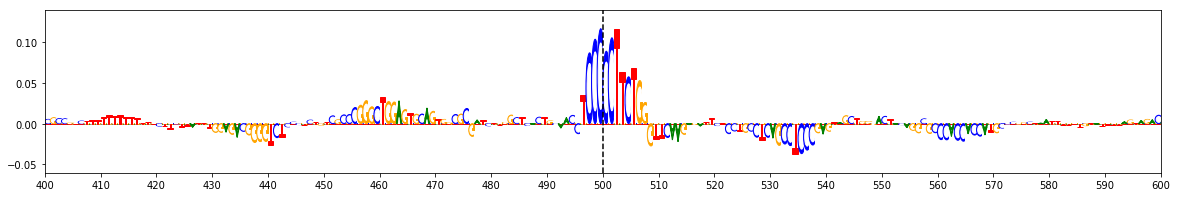

Index:  3  Importance:  -0.22799219740000004  RSID:  rs61781270
Major Allele:  G  Major Sequence:  GCAACCTCCGCCTTCTGGGT


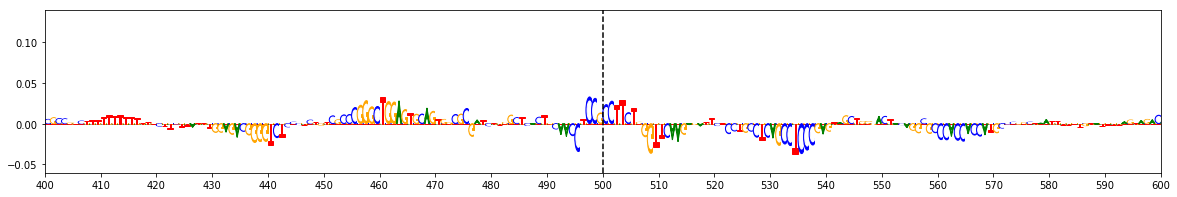

Index:  3  Delta:  0.8230464156000001  RSID:  rs61781270
Minor - Major:  C - G


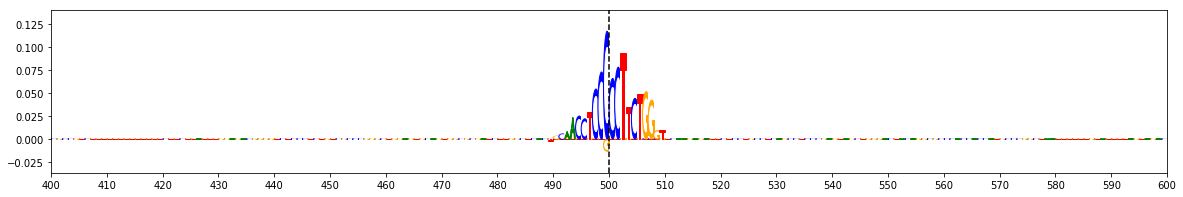

Index:  0  Importance:  -0.057998716900000025  RSID:  rs17504495 chr1 :  40299194  -  40299195  Locus:  152
Minor Allele:  C  Minor Sequence:  GAACTGTCCCGTCCTTTCAG


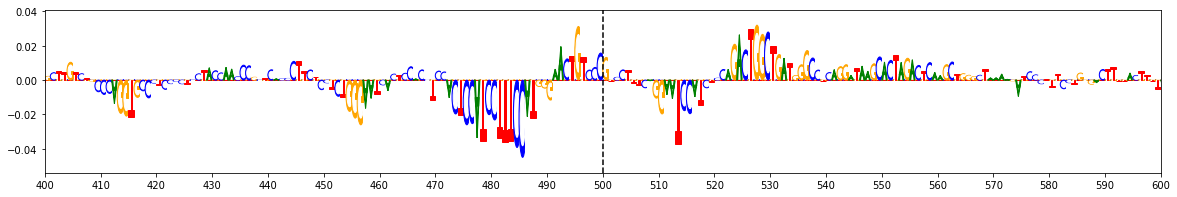

Index:  0  Importance:  -0.24143003620000003  RSID:  rs17504495
Major Allele:  T  Major Sequence:  GAACTGTCCTGTCCTTTCAG


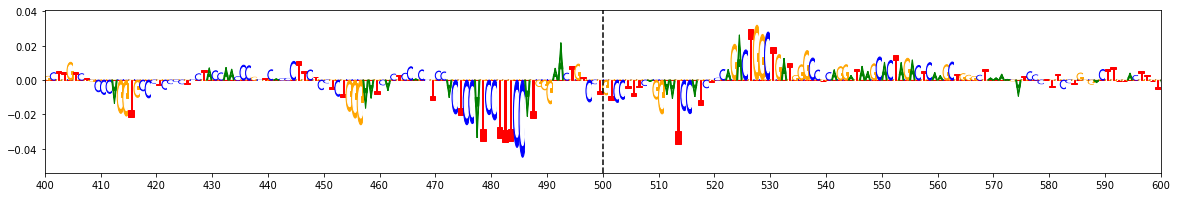

Index:  0  Delta:  0.1834313193  RSID:  rs17504495
Minor - Major:  C - T


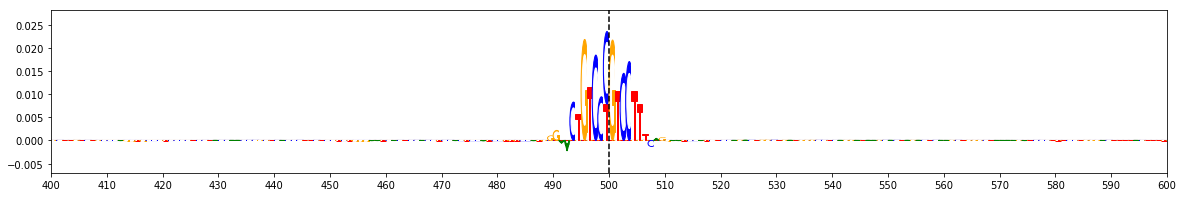

In [9]:
for idx in [3, 0]:
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df_pos.at[idx, 'chr'], ': ', seq_df_pos.at[idx, 'start'], ' - ', seq_df_pos.at[idx, 'end'], " Locus: ", seq_df_pos.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_pos.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

***

# Fold 1 <a name='fold1' />

In [14]:
cluster = '24'
fold = '1'
peak = 'overlap'
gwas = 'Kunkle'

gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

## Prepare Reference Alleles

In [15]:
major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 85


## Prepare Alternate Alleles

In [16]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 85


## Get Unique Loci

In [17]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))

seq_df = pd.DataFrame.from_dict(seq_dict)

loci = []
for i in seq_df.locus.unique():
    loci.append(i)
print("Number of Loci: ", len(seq_df.locus.unique()))
print("Unique Loci: ", loci)

Number of Loci:  4
Unique Loci:  [154, 155, 156, 157]


## Find Alternate Alleles that Break Accessibility

In [18]:
seq_df_neg = seq_df.loc[seq_df['delta'] <= 0]
seq_df_neg.sort_values(by='delta', ascending=True, inplace=True)
display(seq_df_neg)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
8,8,chr19,18548883,18548884,rs2303696,155,C,T,1.316129,0.577593,-0.738536
74,74,chr2,127886157,127886158,rs13025717,157,C,T,1.947943,1.212961,-0.734982
10,10,chr19,18590222,18590223,rs10409483,155,C,G,-1.212314,-1.735625,-0.523311
9,9,chr19,18572833,18572834,rs8103622,155,C,T,1.986588,1.529791,-0.456796
46,46,chr19,45414450,45414451,rs439401,156,C,T,1.387689,0.932079,-0.455610
43,43,chr19,45394335,45394336,rs71352238,156,T,C,2.890652,2.549528,-0.341124
13,13,chr19,18612757,18612758,rs8107351,155,G,A,1.755589,1.442118,-0.313471
23,23,chr19,45242172,45242173,rs1531517,156,G,A,2.158653,1.882019,-0.276635
31,31,chr19,45348252,45348253,rs10426423,156,C,T,1.770959,1.536423,-0.234536
57,57,chr19,45458145,45458146,rs3760629,156,C,A,0.847021,0.614736,-0.232285


## Visualize Top Sequences

Index:  8  Importance:  1.316128574  RSID:  rs2303696   chr19 : 18548883 - 18548884  Locus:  155
Major Allele:  C  Major Sequence:  GGCCGTCCCCGCCCCGAACC


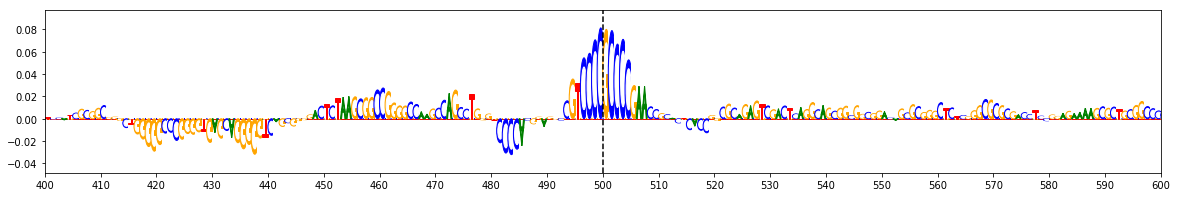

Index:  8  Importance:  0.577592729  RSID:  rs2303696
Minor Allele:  T  Minor Sequence:  GGCCGTCCCTGCCCCGAACC


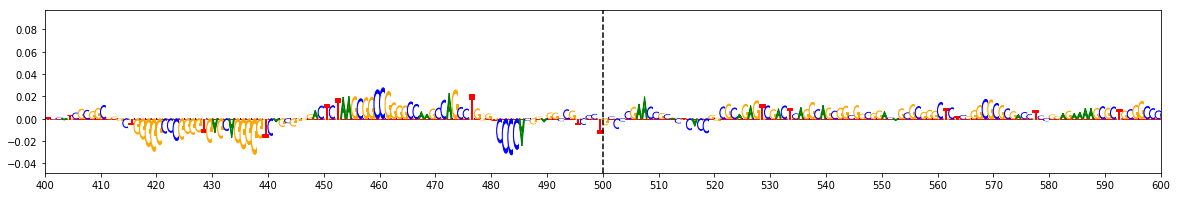

Index:  8  Delta:  -0.7385358449999999  RSID:  rs2303696
Minor - Major:  T - C


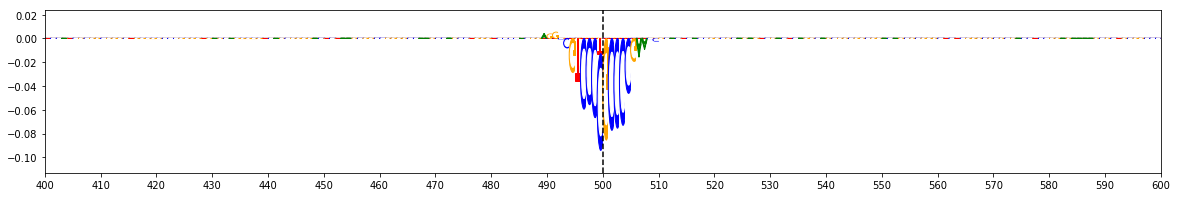

Index:  46  Importance:  1.3876887181  RSID:  rs439401   chr19 : 45414450 - 45414451  Locus:  156
Major Allele:  C  Major Sequence:  ACTCTCTTCCCCTCCCACCC


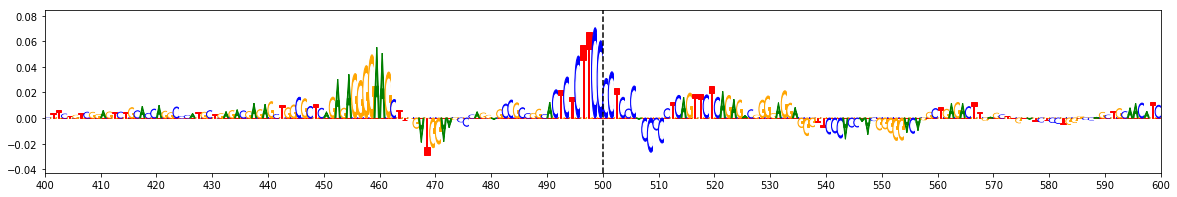

Index:  46  Importance:  0.9320787265999999  RSID:  rs439401
Minor Allele:  T  Minor Sequence:  ACTCTCTTCTCCTCCCACCC


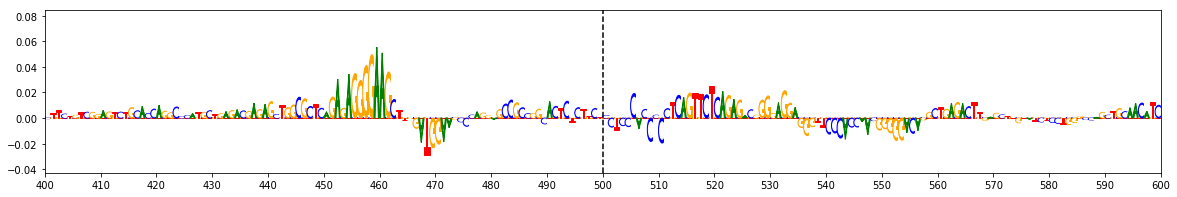

Index:  46  Delta:  -0.45560999150000003  RSID:  rs439401
Minor - Major:  T - C


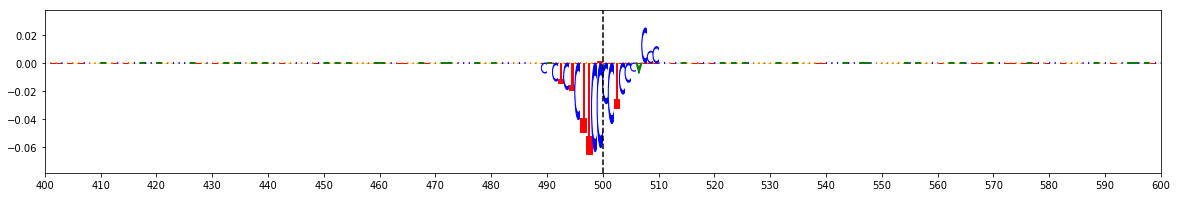

Index:  74  Importance:  1.947942679  RSID:  rs13025717   chr2 : 127886157 - 127886158  Locus:  157
Major Allele:  C  Major Sequence:  CAGAAGCCCCGCCCAATGAG


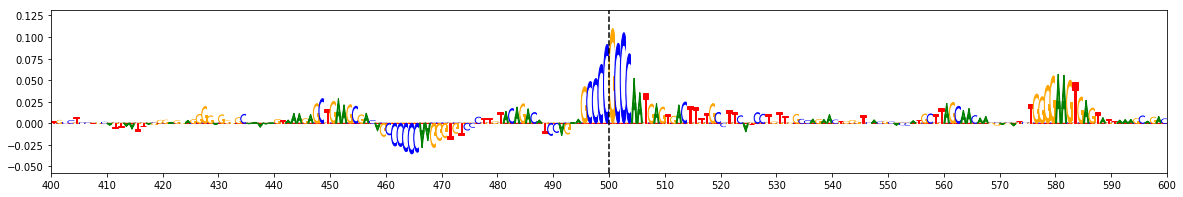

Index:  74  Importance:  1.2129610570000002  RSID:  rs13025717
Minor Allele:  T  Minor Sequence:  CAGAAGCCCTGCCCAATGAG


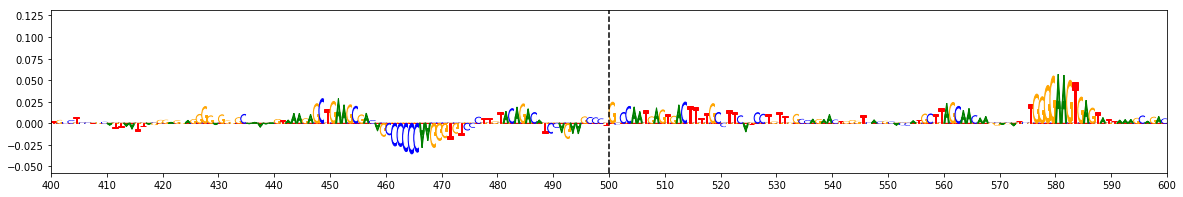

Index:  74  Delta:  -0.7349816219999998  RSID:  rs13025717
Minor - Major:  T - C


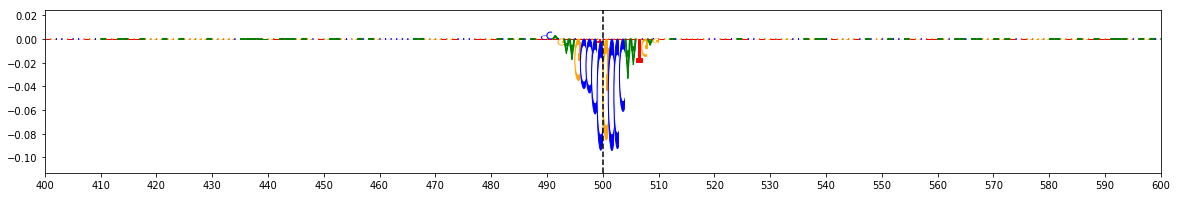

In [27]:
for idx in [8, 46, 74]:
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df_neg.at[idx, 'chr'], ':', seq_df_neg.at[idx, 'start'], '-', seq_df_neg.at[idx, 'end'], " Locus: ", seq_df_neg.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_neg.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [20]:
seq_df_pos = seq_df.loc[seq_df['delta'] > 0]
seq_df_pos.sort_values(by='delta', ascending=False, inplace=True)
display(seq_df_pos)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
72,72,chr2,127878431,127878432,rs4663099,157,A,T,1.809889,2.775139,0.965251
28,28,chr19,45347910,45347911,rs4452060,156,C,A,1.200430,1.611230,0.410800
37,37,chr19,45359585,45359586,rs56317818,156,C,T,0.626849,0.996922,0.370073
65,65,chr2,127841768,127841769,rs10200967,157,T,C,1.008913,1.354136,0.345223
75,75,chr2,127886232,127886233,rs13025765,157,C,T,2.580233,2.914027,0.333794
11,11,chr19,18590250,18590251,rs10409505,155,C,G,-1.663082,-1.334152,0.328930
71,71,chr2,127878431,127878432,rs4663099,157,A,G,1.809889,2.130593,0.320705
83,83,chr2,127894483,127894484,rs730482,157,A,T,0.241382,0.521077,0.279695
2,2,chr19,1038570,1038571,rs1057874,154,T,G,2.048251,2.323293,0.275042
70,70,chr2,127878431,127878432,rs4663099,157,A,C,1.809889,2.084686,0.274797


## Visualize Top Sequences

Index:  15  Importance:  1.527990551  RSID:  rs10426401 chr19 :  45147718  -  45147719  Locus:  156
Minor Allele:  G  Minor Sequence:  CAACACGGGGCGGGCACAAG


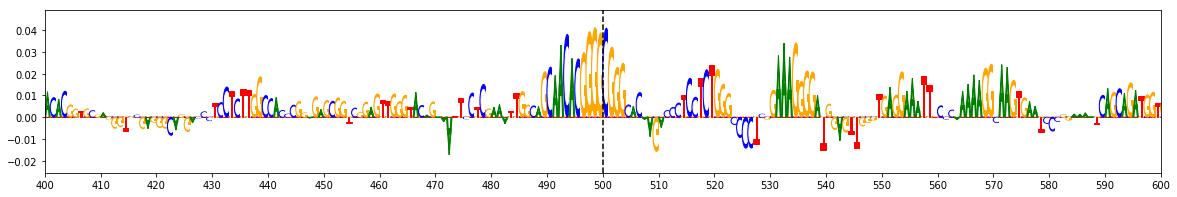

Index:  15  Importance:  1.2836167552000002  RSID:  rs10426401
Major Allele:  T  Major Sequence:  CAACACGGGTCGGGCACAAG


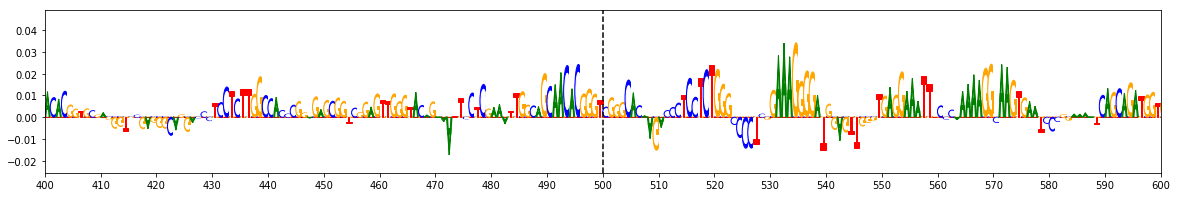

Index:  15  Delta:  0.24437379579999985  RSID:  rs10426401
Minor - Major:  G - T


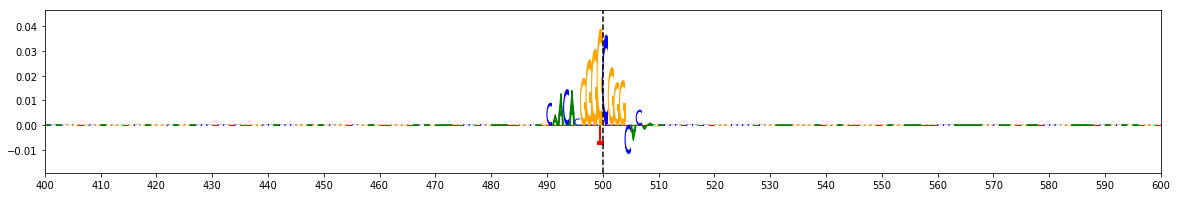

Index:  72  Importance:  2.7751393567  RSID:  rs4663099 chr2 :  127878431  -  127878432  Locus:  157
Minor Allele:  T  Minor Sequence:  TCTCCTTCCTGTTTGCGGTT


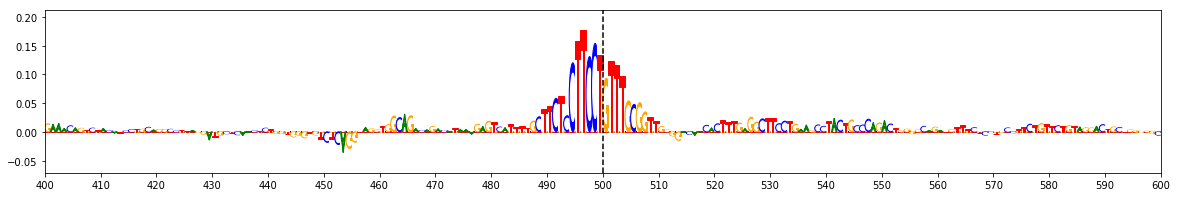

Index:  72  Importance:  1.8098885957  RSID:  rs4663099
Major Allele:  A  Major Sequence:  TCTCCTTCCAGTTTGCGGTT


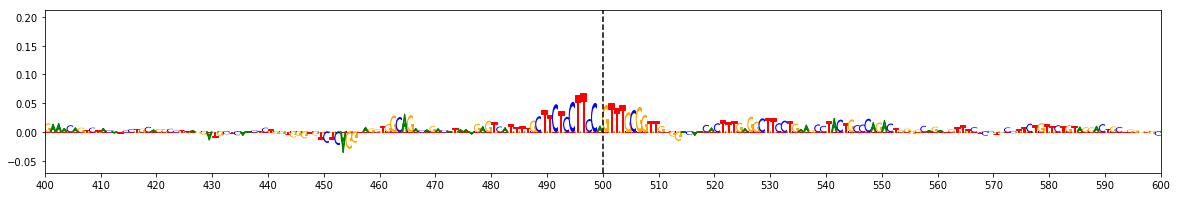

Index:  72  Delta:  0.9652507610000001  RSID:  rs4663099
Minor - Major:  T - A


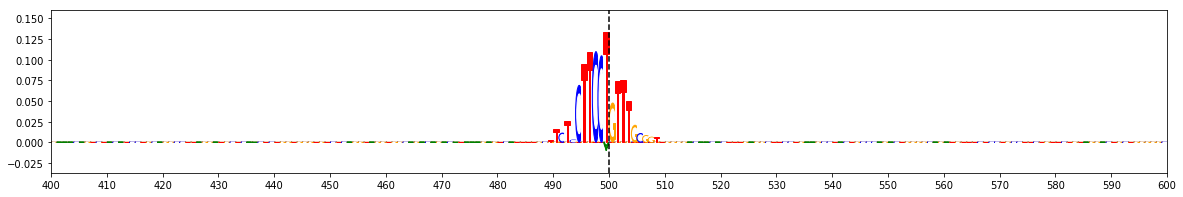

Index:  71  Importance:  2.130593147  RSID:  rs4663099 chr2 :  127878431  -  127878432  Locus:  157
Minor Allele:  G  Minor Sequence:  TCTCCTTCCGGTTTGCGGTT


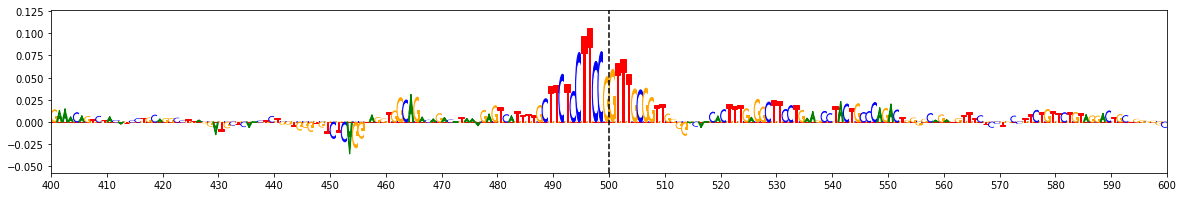

Index:  71  Importance:  1.8098885957  RSID:  rs4663099
Major Allele:  A  Major Sequence:  TCTCCTTCCAGTTTGCGGTT


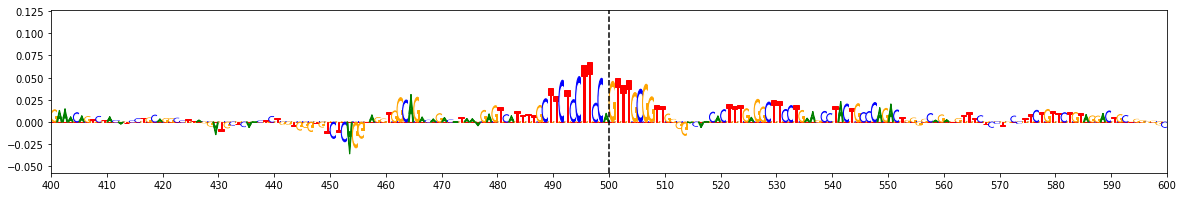

Index:  71  Delta:  0.3207045513  RSID:  rs4663099
Minor - Major:  G - A


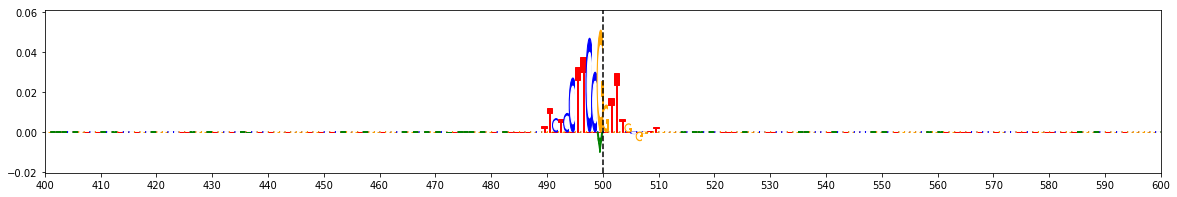

In [28]:
for idx in [15, 72, 71]:
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df_pos.at[idx, 'chr'], ': ', seq_df_pos.at[idx, 'start'], ' - ', seq_df_pos.at[idx, 'end'], " Locus: ", seq_df_pos.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_pos.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

***

# Fold 6 <a name='fold6' />

In [29]:
cluster = '24'
fold = '6'
peak = 'overlap'
gwas = 'Kunkle'

gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

## Prepare Reference Alleles

In [30]:
major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 1


## Prepare Alternate Alleles

In [31]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 1


## Get Unique Loci

In [32]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))

seq_df = pd.DataFrame.from_dict(seq_dict)

loci = []
for i in seq_df.locus.unique():
    loci.append(i)
print("Number of Loci: ", len(seq_df.locus.unique()))
print("Unique Loci: ", loci)

Number of Loci:  1
Unique Loci:  [160]


## Find Alternate Alleles that Break Accessibility

In [33]:
seq_df_neg = seq_df.loc[seq_df['delta'] <= 0]
seq_df_neg.sort_values(by='delta', ascending=True, inplace=True)
display(seq_df_neg)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
0,0,chr7,143107875,143107876,rs11762262,160,C,T,0.583746,0.514458,-0.069288


## Visualize Top Sequences

Index:  0  Importance:  0.5837461271  RSID:  rs11762262   chr7 : 143107875 - 143107876  Locus:  160
Major Allele:  C  Major Sequence:  TCTGACACACATTGCTCTGC


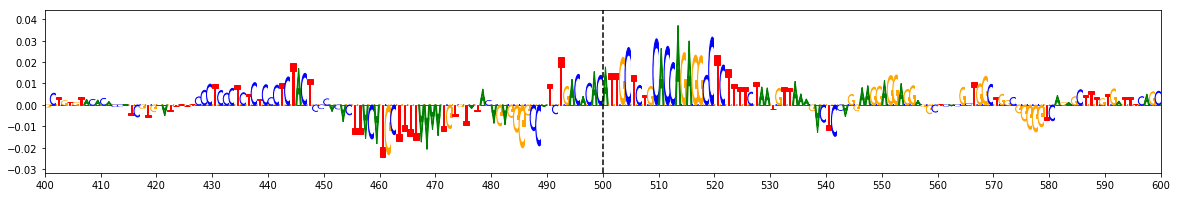

Index:  0  Importance:  0.5144582294000001  RSID:  rs11762262
Minor Allele:  T  Minor Sequence:  TCTGACACATATTGCTCTGC


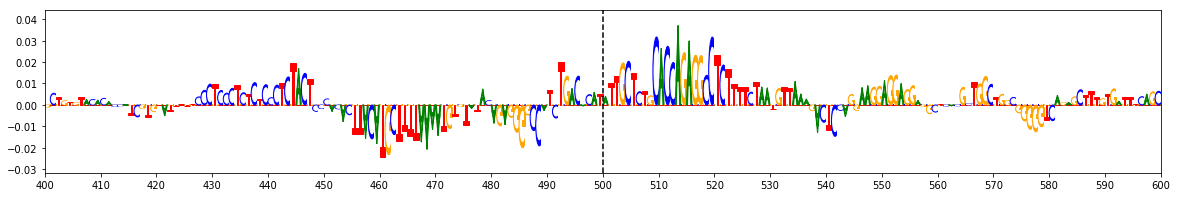

Index:  0  Delta:  -0.06928789769999988  RSID:  rs11762262
Minor - Major:  T - C


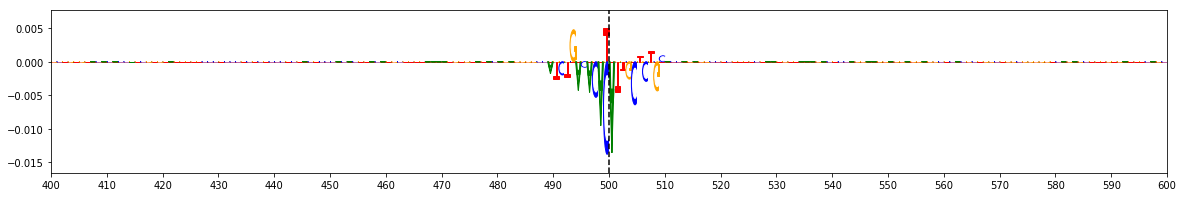

In [34]:
for idx in [0]:
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df_neg.at[idx, 'chr'], ':', seq_df_neg.at[idx, 'start'], '-', seq_df_neg.at[idx, 'end'], " Locus: ", seq_df_neg.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_neg.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

***

# Fold 7 <a name='fold7' />

In [36]:
cluster = '24'
fold = '7'
peak = 'overlap'
gwas = 'Kunkle'

gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

## Prepare Reference Alleles

In [37]:
major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 41


## Prepare Alternate Alleles

In [38]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 41


## Get Unique Loci

In [39]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))

seq_df = pd.DataFrame.from_dict(seq_dict)

loci = []
for i in seq_df.locus.unique():
    loci.append(i)
print("Number of Loci: ", len(seq_df.locus.unique()))
print("Unique Loci: ", loci)

Number of Loci:  3
Unique Loci:  [148, 149, 150]


## Find Alternate Alleles that Break Accessibility

In [40]:
seq_df_neg = seq_df.loc[seq_df['delta'] <= 0]
seq_df_neg.sort_values(by='delta', ascending=True, inplace=True)
display(seq_df_neg)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
33,33,chr11,85779161,85779162,rs2509609,150,G,A,1.863188,1.282015,-0.581173
32,32,chr11,85779161,85779162,rs2509609,150,G,C,1.863188,1.345971,-0.517218
14,14,chr11,59951432,59951433,rs632185,149,G,A,1.649759,1.298187,-0.351572
19,19,chr11,60002934,60002935,rs718376,149,G,A,1.790668,1.539173,-0.251495
28,28,chr11,60031475,60031476,rs10736701,149,T,C,0.877373,0.644954,-0.232419
25,25,chr11,60031269,60031270,rs7128450,149,C,G,1.058709,0.840660,-0.218049
30,30,chr11,60078474,60078475,rs61900467,149,C,T,1.028374,0.843297,-0.185077
13,13,chr11,47902882,47902883,rs12364432,148,G,C,2.041510,1.858701,-0.182809
37,37,chr11,85828550,85828551,rs474479,150,G,C,1.476450,1.305661,-0.170789
24,24,chr11,60027308,60027309,rs1365247,149,C,T,2.836531,2.688468,-0.148063


## Visualize Top Sequences

Index:  33  Importance:  1.8631882792  RSID:  rs2509609   chr11 : 85779161 - 85779162  Locus:  150
Major Allele:  G  Major Sequence:  AGGGATGGGGGAAGCAGCTA


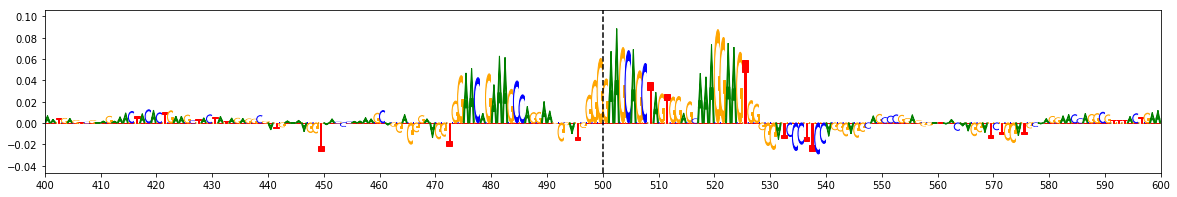

Index:  33  Importance:  1.2820154165000002  RSID:  rs2509609
Minor Allele:  A  Minor Sequence:  AGGGATGGGAGAAGCAGCTA


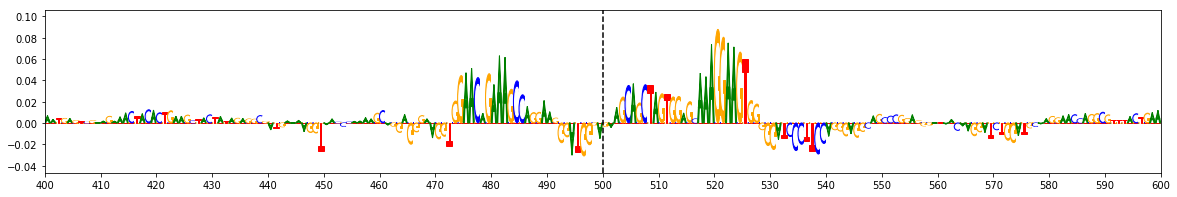

Index:  33  Delta:  -0.5811728626999999  RSID:  rs2509609
Minor - Major:  A - G


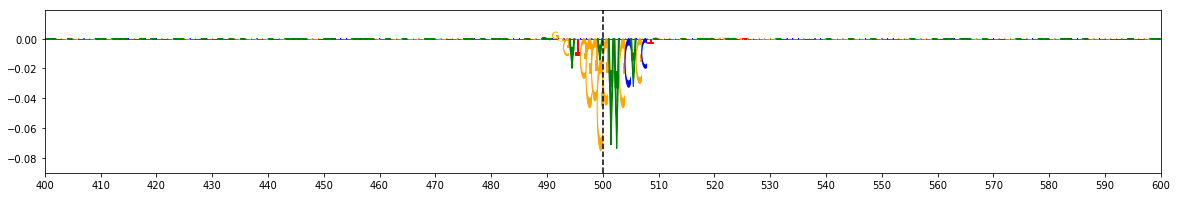

In [49]:
for idx in [33]:
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df_neg.at[idx, 'chr'], ':', seq_df_neg.at[idx, 'start'], '-', seq_df_neg.at[idx, 'end'], " Locus: ", seq_df_neg.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_neg.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [45]:
seq_df_pos = seq_df.loc[seq_df['delta'] > 0]
seq_df_pos.sort_values(by='delta', ascending=False, inplace=True)
display(seq_df_pos)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
20,20,chr11,60019149,60019150,rs636317,149,T,C,1.656542,3.299272,1.642730
40,40,chr11,85867874,85867875,rs10792832,150,G,A,1.094689,1.470480,0.375790
17,17,chr11,59988861,59988862,rs584469,149,T,G,1.705030,2.043117,0.338087
39,39,chr11,85852978,85852979,rs10792831,150,A,G,2.363931,2.701221,0.337290
0,0,chr11,47398962,47398963,rs12146565,148,G,A,-0.392465,-0.069623,0.322842
1,1,chr11,47399601,47399602,rs2278890,148,G,A,0.433770,0.662054,0.228284
26,26,chr11,60031398,60031399,rs10736700,149,C,T,0.172574,0.367345,0.194772
3,3,chr11,47416635,47416636,rs55876153,148,G,C,0.170297,0.362318,0.192021
27,27,chr11,60031398,60031399,rs10736700,149,C,A,0.172574,0.356640,0.184066
7,7,chr11,47429903,47429904,rs7947450,148,G,A,3.067069,3.248758,0.181689


## Visualize Top Sequences

Index:  0  Importance:  -0.06962313400000002  RSID:  rs12146565 chr11 :  47398962  -  47398963  Locus:  148
Minor Allele:  A  Minor Sequence:  GAAAAGGGAAAAGGGTCCTT


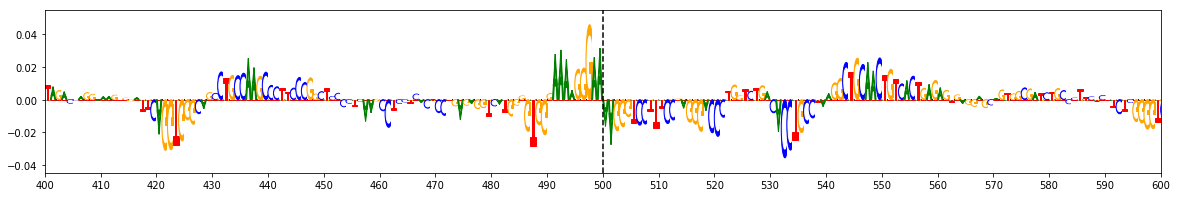

Index:  0  Importance:  -0.39246520100000004  RSID:  rs12146565
Major Allele:  G  Major Sequence:  GAAAAGGGAGAAGGGTCCTT


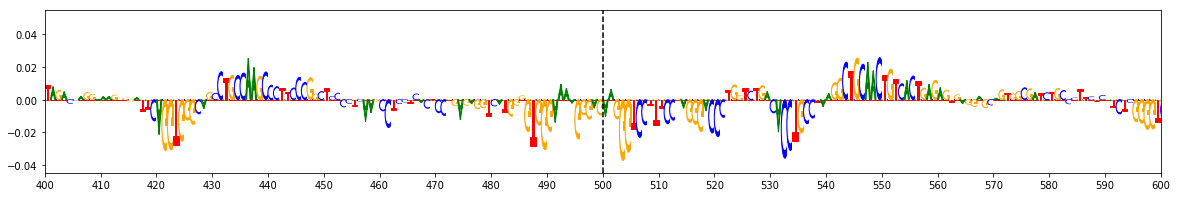

Index:  0  Delta:  0.322842067  RSID:  rs12146565
Minor - Major:  A - G


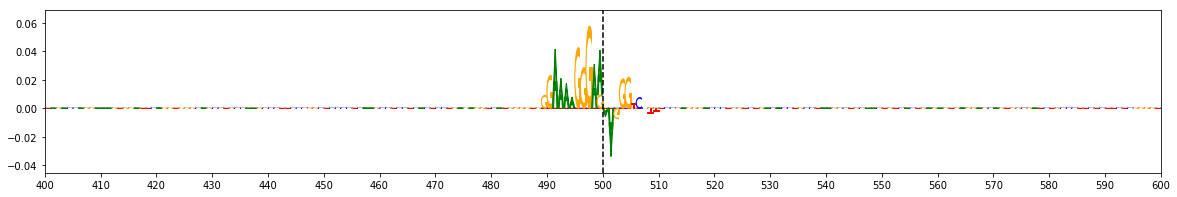

Index:  20  Importance:  3.2992722879999996  RSID:  rs636317 chr11 :  60019149  -  60019150  Locus:  149
Minor Allele:  C  Minor Sequence:  CTTTGCTGCCATCTGCTGGG


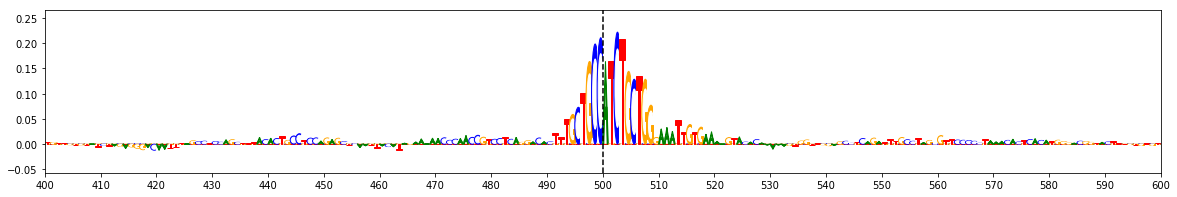

Index:  20  Importance:  1.6565424143  RSID:  rs636317
Major Allele:  T  Major Sequence:  CTTTGCTGCTATCTGCTGGG


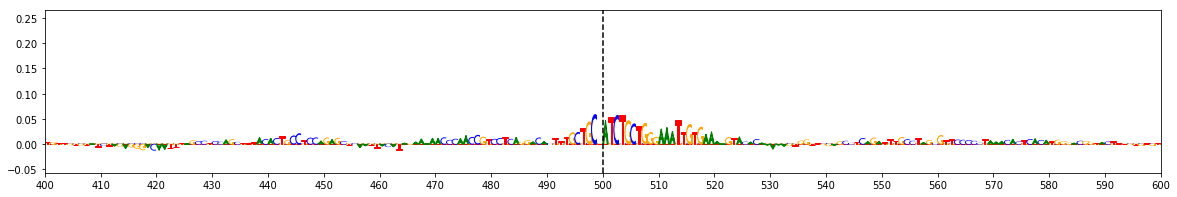

Index:  20  Delta:  1.6427298736999996  RSID:  rs636317
Minor - Major:  C - T


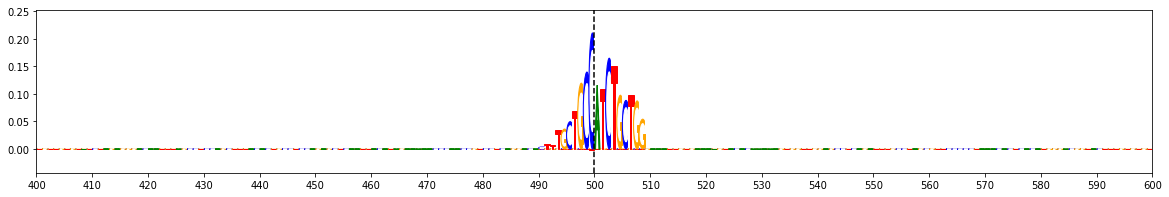

Index:  21  Importance:  3.1576646739300003  RSID:  rs636341 chr11 :  60019160  -  60019161  Locus:  149
Minor Allele:  A  Minor Sequence:  TCTGCTGGGAAATTGTGAAA


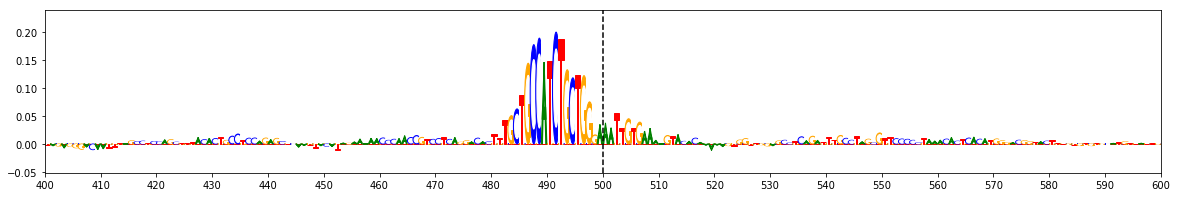

Index:  21  Importance:  3.01649170566  RSID:  rs636341
Major Allele:  C  Major Sequence:  TCTGCTGGGCAATTGTGAAA


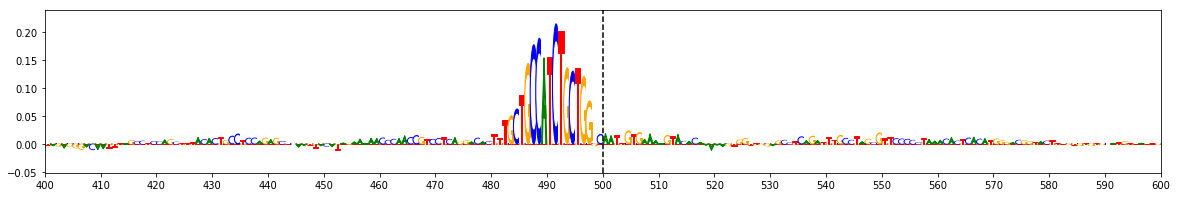

Index:  21  Delta:  0.14117296827000025  RSID:  rs636341
Minor - Major:  A - C


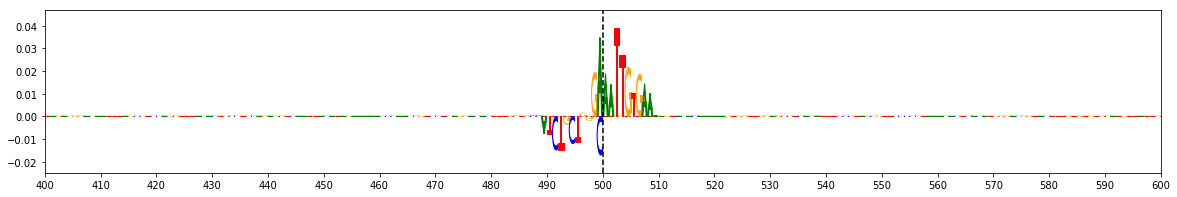

Index:  39  Importance:  2.7012207467  RSID:  rs10792831 chr11 :  85852978  -  85852979  Locus:  150
Minor Allele:  G  Minor Sequence:  GGGGAACAGGAAGGTTGATC


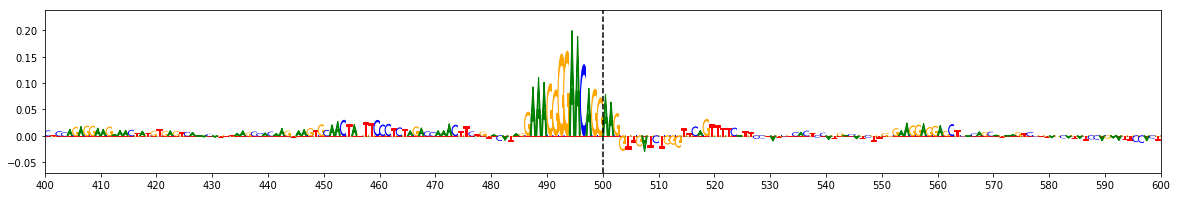

Index:  39  Importance:  2.3639307448  RSID:  rs10792831
Major Allele:  A  Major Sequence:  GGGGAACAGAAAGGTTGATC


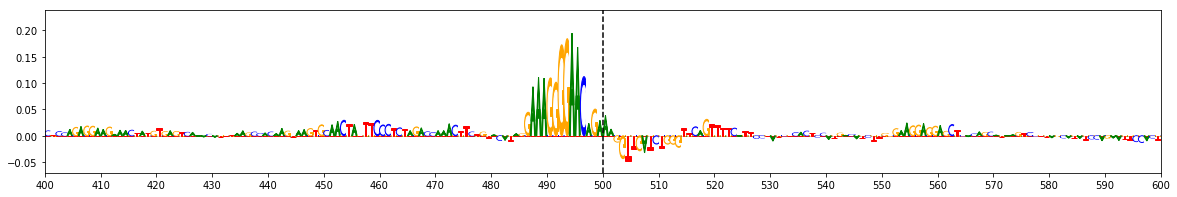

Index:  39  Delta:  0.3372900018999996  RSID:  rs10792831
Minor - Major:  G - A


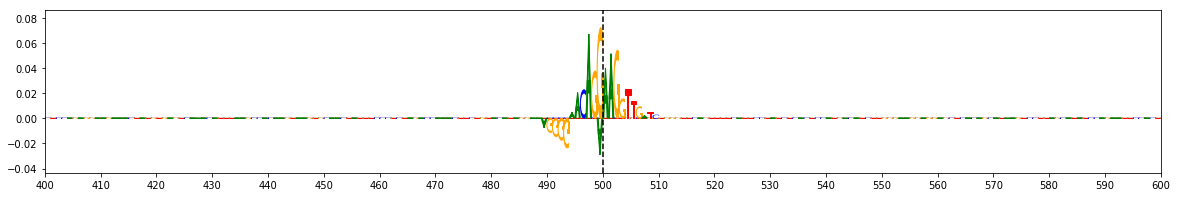

In [50]:
for idx in [0, 20, 21, 39]:
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df_pos.at[idx, 'chr'], ': ', seq_df_pos.at[idx, 'start'], ' - ', seq_df_pos.at[idx, 'end'], " Locus: ", seq_df_pos.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_pos.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

***

# Fold 9 <a name='fold9' />

In [51]:
cluster = '24'
fold = '9'
peak = 'overlap'
gwas = 'Kunkle'

gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

## Prepare Reference Alleles

In [52]:
major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 3


## Prepare Alternate Alleles

In [53]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 3


## Get Unique Loci

In [54]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))

seq_df = pd.DataFrame.from_dict(seq_dict)

loci = []
for i in seq_df.locus.unique():
    loci.append(i)
print("Number of Loci: ", len(seq_df.locus.unique()))
print("Unique Loci: ", loci)

Number of Loci:  1
Unique Loci:  [161]


## Find Alternate Alleles that Break Accessibility

In [55]:
seq_df_neg = seq_df.loc[seq_df['delta'] <= 0]
seq_df_neg.sort_values(by='delta', ascending=True, inplace=True)
display(seq_df_neg)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
1,1,chr8,27226789,27226790,rs755951,161,A,T,-0.594121,-0.681722,-0.0876


## Visualize Top Sequences

Index:  1  Importance:  -0.5941214895000001  RSID:  rs755951   chr8 : 27226789 - 27226790  Locus:  161
Major Allele:  A  Major Sequence:  TTCACTGGCATGTAGGGGGA


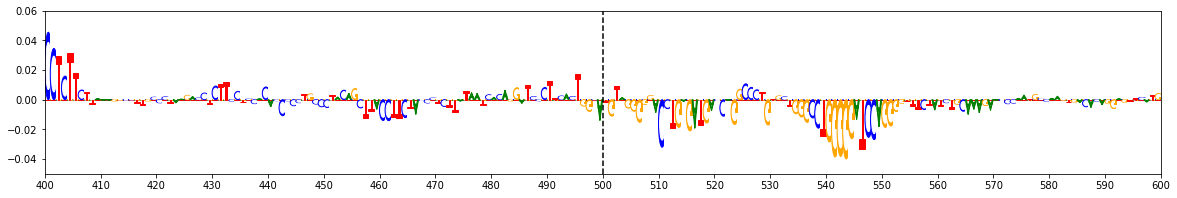

Index:  1  Importance:  -0.6817219513999999  RSID:  rs755951
Minor Allele:  T  Minor Sequence:  TTCACTGGCTTGTAGGGGGA


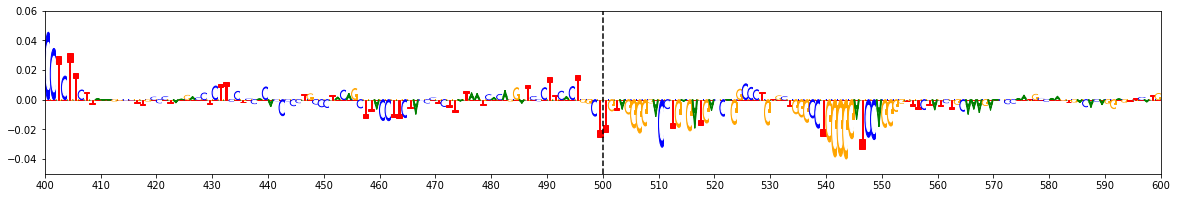

Index:  1  Delta:  -0.08760046189999982  RSID:  rs755951
Minor - Major:  T - A


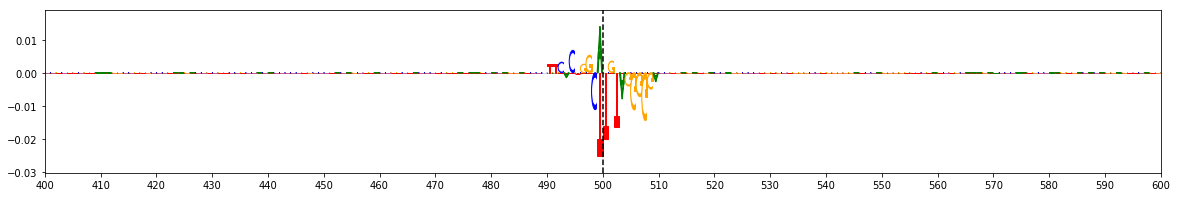

In [56]:
for idx in [1]:
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df_neg.at[idx, 'chr'], ':', seq_df_neg.at[idx, 'start'], '-', seq_df_neg.at[idx, 'end'], " Locus: ", seq_df_neg.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_neg.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [57]:
seq_df_pos = seq_df.loc[seq_df['delta'] > 0]
seq_df_pos.sort_values(by='delta', ascending=False, inplace=True)
display(seq_df_pos)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
0,0,chr8,27226789,27226790,rs755951,161,A,C,-0.594121,0.172130,0.766251
2,2,chr8,27456252,27456253,rs2279590,161,C,T,2.024471,2.291536,0.267065


## Visualize Top Sequences

Index:  0  Importance:  0.17212956310000005  RSID:  rs755951 chr8 :  27226789  -  27226790  Locus:  161
Minor Allele:  C  Minor Sequence:  TTCACTGGCCTGTAGGGGGA


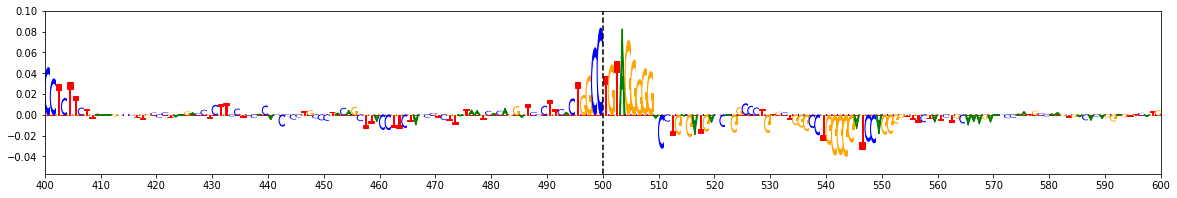

Index:  0  Importance:  -0.5941214895000001  RSID:  rs755951
Major Allele:  A  Major Sequence:  TTCACTGGCATGTAGGGGGA


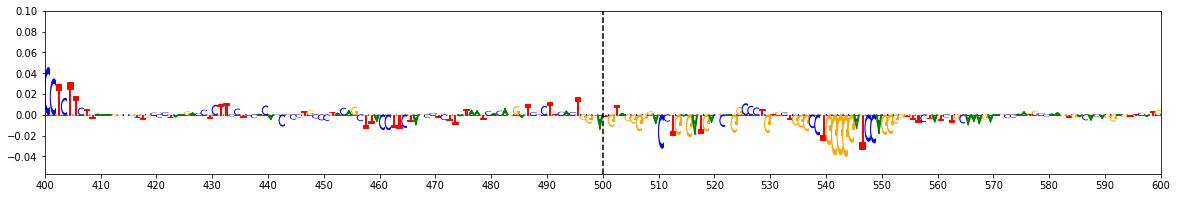

Index:  0  Delta:  0.7662510526000001  RSID:  rs755951
Minor - Major:  C - A


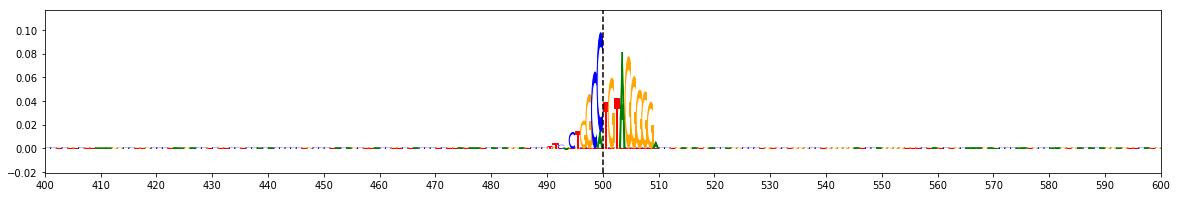

Index:  2  Importance:  2.2915356164  RSID:  rs2279590 chr8 :  27456252  -  27456253  Locus:  161
Minor Allele:  T  Minor Sequence:  CCTCCTGCTTCTCCAAGGAA


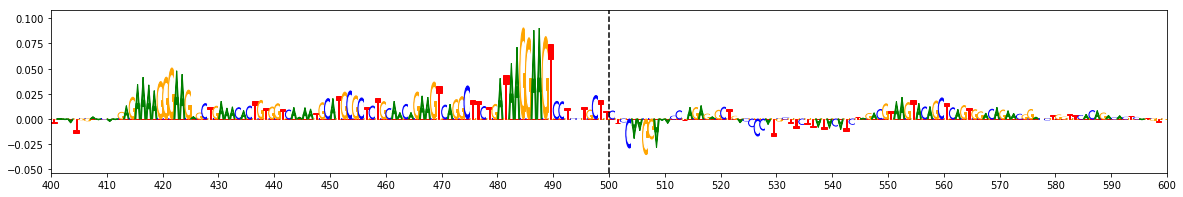

Index:  2  Importance:  2.0244710018000003  RSID:  rs2279590
Major Allele:  C  Major Sequence:  CCTCCTGCTCCTCCAAGGAA


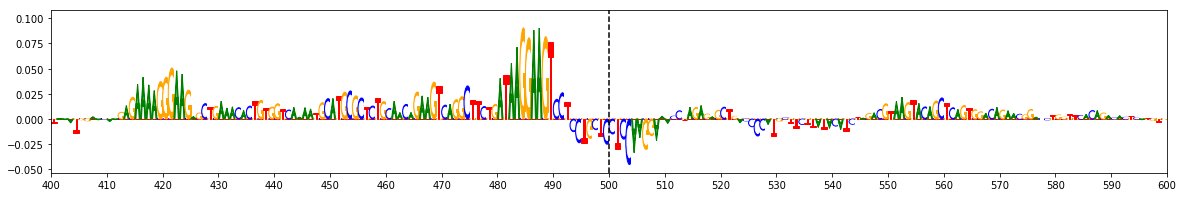

Index:  2  Delta:  0.26706461459999975  RSID:  rs2279590
Minor - Major:  T - C


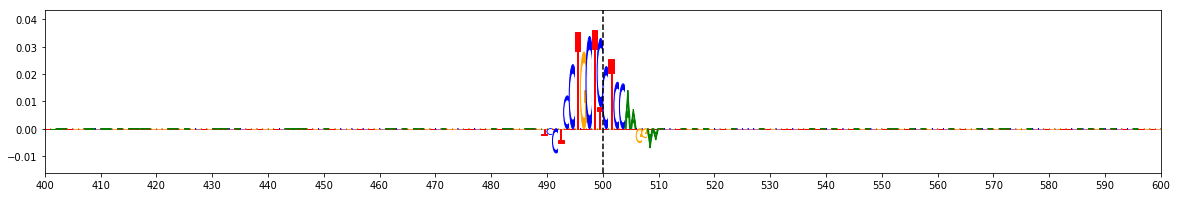

In [58]:
for idx in [0, 2]:
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df_pos.at[idx, 'chr'], ': ', seq_df_pos.at[idx, 'start'], ' - ', seq_df_pos.at[idx, 'end'], " Locus: ", seq_df_pos.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_pos.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

***